Original Class Distribution:
 Label
Entertainment    44834
Technology       30107
Business         24834
Health           12020
Name: count, dtype: int64


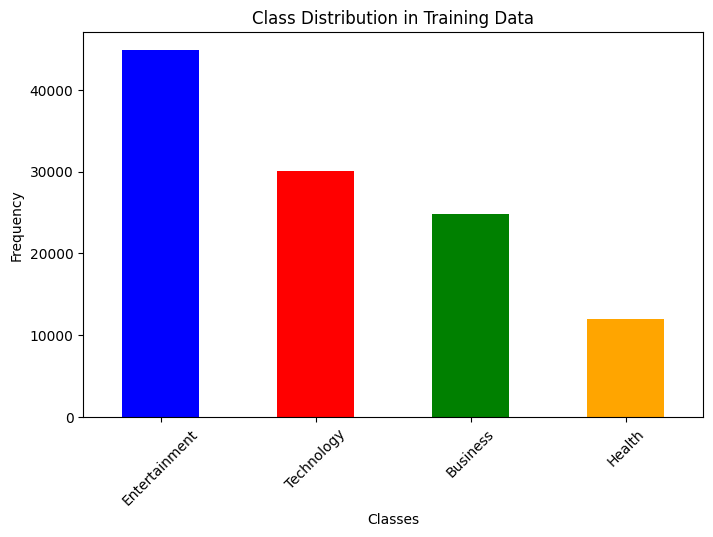

In [1]:
import os
import pandas as pd
import re
import numpy as np
import nltk
import matplotlib.pyplot as plt
import sys
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Load dataset
train_df = pd.read_csv("train.csv")

# Check the class distribution
class_counts = train_df['Label'].value_counts()
print("Original Class Distribution:\n", class_counts)

# Plot class distribution
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color=['blue', 'red', 'green', 'orange'])
plt.title("Class Distribution in Training Data")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


In [2]:
# Find the minimum class count (smallest category size)
min_samples = train_df['Label'].value_counts().min()

# Create a balanced dataset by sampling min_samples from each class
balanced_df = train_df.groupby('Label').apply(lambda x: x.sample(min_samples, random_state=42)).reset_index(drop=True)

# Check new distribution
print("Balanced Class Distribution:\n", balanced_df['Label'].value_counts())

# Save the balanced dataset for future use
balanced_df.to_csv("balanced_train.csv", index=False)
print("Balanced dataset saved as balanced_train.csv!")

C:\Users\mitso\AppData\Local\Temp\ipykernel_9156\3426988539.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = train_df.groupby('Label').apply(lambda x: x.sample(min_samples, random_state=42)).reset_index(drop=True)


Balanced Class Distribution:
 Label
Business         12020
Entertainment    12020
Health           12020
Technology       12020
Name: count, dtype: int64
Balanced dataset saved as balanced_train.csv!


In [3]:
# Load balanced dataset instead of the original one
train_df = pd.read_csv("balanced_train.csv")

# Load the test dataset
test_unlabeled_df = pd.read_csv("test_without_labels.csv")

print(f"Balanced Training Data: {train_df.shape} rows")
print(f"Test Data: {test_unlabeled_df.shape} rows")

Balanced Training Data: (48080, 4) rows
Test Data: (47912, 3) rows


In [4]:
# Text Preprocessing Function
def preprocess_text(text):
    if pd.isnull(text):  # Handle NaN values
        return ""
    
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation and numbers
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    
    return ' '.join(tokens)

# Function to preprocess entire dataset
def preprocess_dataset(df, text_columns):
    for col in text_columns:
        df[col] = df[col].astype(str).apply(preprocess_text)
    return df

print("Preprocessing functions are ready!")

Preprocessing functions are ready!


In [5]:
# Define file paths
train_path = "preprocessed_train_balanced.csv"
test_path = "preprocessed_test.csv"

# Check if preprocessed files exist
if os.path.exists(train_path) and os.path.exists(test_path):
    print("Preprocessed files found! Do you want to recompute preprocessing? (yes/no)")
    user_input = input().strip().lower()

    if user_input == "yes":
        recompute = True
    elif user_input == "no":
        recompute = False
    else:
        print("Invalid input! Defaulting to using existing files.")
        recompute = False
else:
    recompute = True  # If files don’t exist, we must recompute.

if not recompute:
    print("Loading preprocessed data...")
    train_df = pd.read_csv(train_path)
    test_unlabeled_df = pd.read_csv(test_path)
    print("Data loaded successfully.")
else:
    print("Running preprocessing...")

    text_columns = ['Title', 'Content']
    print("Preprocessing text data...")

    for col in text_columns:
        print(f"\nProcessing column: {col}")
        
        total_rows = len(train_df) + len(test_unlabeled_df)  # Total rows to process
        processed_rows = 0  # Track processed rows

        # Process training data
        for i in range(len(train_df)):
            train_df.at[i, col] = preprocess_text(str(train_df.at[i, col]))
            processed_rows += 1
            percentage = (processed_rows / total_rows) * 100
            sys.stdout.write(f"\rProgress: {percentage:.2f}%")
            sys.stdout.flush()

        # Process test data
        for i in range(len(test_unlabeled_df)):
            test_unlabeled_df.at[i, col] = preprocess_text(str(test_unlabeled_df.at[i, col]))
            processed_rows += 1
            percentage = (processed_rows / total_rows) * 100
            sys.stdout.write(f"\rProgress: {percentage:.2f}%")
            sys.stdout.flush()

    print("\nPreprocessing complete!")

    # Combine 'Title' and 'Content' into a single field
    print("Combining Title and Content into a single field...")
    train_df['Combined'] = train_df['Title'] + ' ' + train_df['Content']
    test_unlabeled_df['Combined'] = test_unlabeled_df['Title'] + ' ' + test_unlabeled_df['Content']
    print("Combining complete!")

    # Save preprocessed data
    train_df.to_csv(train_path, index=False)
    test_unlabeled_df.to_csv(test_path, index=False)

    print(f"Preprocessed data saved: {train_path}, {test_path}")

Preprocessed files found! Do you want to recompute preprocessing? (yes/no)
yes
Running preprocessing...
Preprocessing text data...

Processing column: Title
Progress: 100.00%
Processing column: Content
Progress: 100.00%
Preprocessing complete!
Combining Title and Content into a single field...
Combining complete!
Preprocessed data saved: preprocessed_train_balanced.csv, preprocessed_test.csv


Final class distribution after preprocessing:
Label
Business         12020
Entertainment    12020
Health           12020
Technology       12020
Name: count, dtype: int64


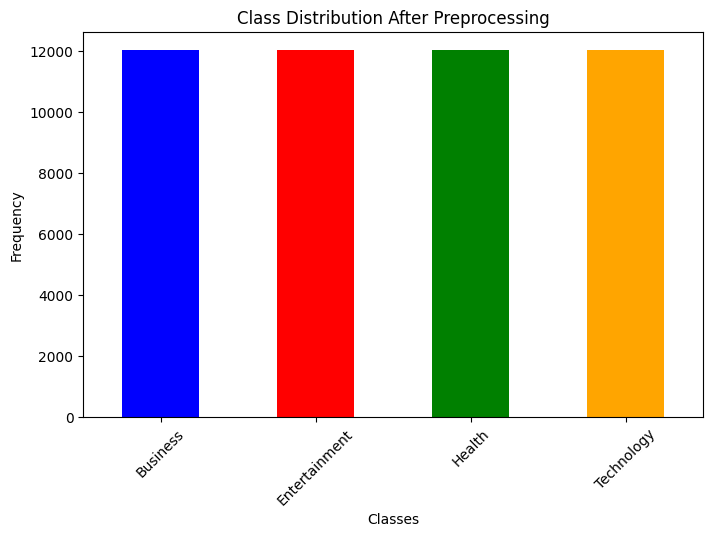

In [6]:
# Count each class after balancing
print("Final class distribution after preprocessing:")
print(train_df['Label'].value_counts())

# Plot class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
train_df['Label'].value_counts().plot(kind='bar', color=['blue', 'red', 'green', 'orange'])
plt.title("Class Distribution After Preprocessing")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [7]:
# Load Preprocessed Data
print("Loading preprocessed datasets...")
train_df = pd.read_csv("preprocessed_train_balanced.csv")
test_df = pd.read_csv("preprocessed_test.csv")
#print(f"Train set size: {len(train_df)}, Test set size: {len(test_df)}")
print(f"Train set size: {len(train_df)}, Columns: {list(train_df.columns)}")
print(f"Test set size: {len(test_df)}, Columns: {list(test_df.columns)}")

from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])

print(f"Labels encoded! Unique classes: {len(label_encoder.classes_)}")

RANDOM_SEED = 42

# Use a subset of the training set
subset_size = 1  # Adjust if needed
train_subset_df = train_df.sample(frac=subset_size, random_state=RANDOM_SEED)

X_train_val = train_subset_df['Combined'].values
y_train_val = train_subset_df['Label'].values
X_test_unlabeled = test_unlabeled_df['Combined'].values

print(f"Training on {subset_size * 100}% of the dataset")


# Define SVM Pipeline
svm_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1,1), max_features=10000)), # Unigrams, BoW feature extraction
    ('classifier', SVC(kernel='rbf', gamma='auto', C=100, class_weight='balanced', random_state=RANDOM_SEED))
    # Kernel type rbf
    # gamma - for Kernel coefficient for rbf
    # C - Regularization parameter
])

# Define Random Forest Pipeline
rf_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1,2), max_features=10000)), # Bigrams, BoW feature extraction
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2,
                                          min_samples_leaf=1, class_weight='balanced', random_state=RANDOM_SEED))
    # n_estimators - Number of trees
    # max_depth - Tree depth
    # Minimum samples to split
    # Minimum samples per leaf
])

print("Model pipelines defined!")

# Function to train & evaluate models
def train_and_evaluate_pipeline(X, y, pipeline, method="Model"):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    accuracies = []

    print(f"Evaluating {method} with 5-Fold Cross Validation...")

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        X_train, X_test_fold = X[train_idx], X[test_idx]
        y_train, y_test_fold = y[train_idx], y[test_idx]

        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test_fold)
        fold_accuracy = metrics.accuracy_score(y_test_fold, predictions)
        accuracies.append(fold_accuracy)
        print(f"Fold {fold} Accuracy: {fold_accuracy:.4f}")

    mean_accuracy = np.mean(accuracies)
    print(f"Average Accuracy for {method}: {mean_accuracy:.4f}")
    return mean_accuracy, pipeline

# Train & evaluate models
svm_accuracy, svm_pipeline = train_and_evaluate_pipeline(X_train_val, y_train_val, svm_pipeline, method="SVM")
rf_accuracy, rf_pipeline = train_and_evaluate_pipeline(X_train_val, y_train_val, rf_pipeline, method="Random Forest")

print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Use the best model
best_pipeline = svm_pipeline if svm_accuracy > rf_accuracy else rf_pipeline
print(f"Using the best model: {'SVM' if svm_accuracy > rf_accuracy else 'Random Forest'}")

# Make predictions
print("Making predictions on the test set...")
test_predictions = best_pipeline.predict(X_test_unlabeled)

# Save predictions
output_df = pd.DataFrame({
    "Id": test_unlabeled_df["Id"],
    "Predicted": label_encoder.inverse_transform(test_predictions)
})
output_df.to_csv("testSet_categories_balanced.csv", index=False)

print("Predictions saved to testSet_categories_balanced.csv!")


Loading preprocessed datasets...
Train set size: 48080, Columns: ['Id', 'Title', 'Content', 'Label', 'Combined']
Test set size: 47912, Columns: ['Id', 'Title', 'Content', 'Combined']
Labels encoded! Unique classes: 4
Training on 100% of the dataset
Model pipelines defined!
Evaluating SVM with 5-Fold Cross Validation...
Fold 1 Accuracy: 0.9514
Fold 2 Accuracy: 0.9481
Fold 3 Accuracy: 0.9493
Fold 4 Accuracy: 0.9515
Fold 5 Accuracy: 0.9530
Average Accuracy for SVM: 0.9507
Evaluating Random Forest with 5-Fold Cross Validation...
Fold 1 Accuracy: 0.9316
Fold 2 Accuracy: 0.9217
Fold 3 Accuracy: 0.9316
Fold 4 Accuracy: 0.9283
Fold 5 Accuracy: 0.9290
Average Accuracy for Random Forest: 0.9284
SVM Accuracy: 0.9507
Random Forest Accuracy: 0.9284
Using the best model: SVM
Making predictions on the test set...
Predictions saved to testSet_categories_balanced.csv!
